# Deterministic slice flows

Consider a target density $\pi(x_{1:M},u_{1:M})=p(x_{1:M})1_{[0,1]}(u_{1:M})$ 
where we have access to the full conditionals $p_m$ 
and let $F_m,Q_m$ be the cdf and quantile functions of $p_m$.
We approximate $\pi$ with a variational ergodic flow
$$
    q_N=\frac{1}{N}\sum_{n=0}^N T^nq_0,
$$
where $q_0$ is a reference distribution and
$T=T_m\circ\cdots\circ T_1$ mimics Gibbs sampling, i.e.,
each map $T_m$ updates only $(x_m,u_m)\mapsto(x_m',u_m')$.
Specifically,
$$
\begin{pmatrix}x_m'\\u_m'\end{pmatrix}=
\begin{pmatrix}
    Q_m(\rho(x_m,u_m)+\xi\mod 1)\\ 
    \frac{1}{p_m(x_m')}((\rho(x_m,u_m)+\xi\mod 1)-F(x_m'))
\end{pmatrix},
$$
where $\rho(x,u)=F_m(x-1)+up_m(x)$ converts to proportions and $F_m(0)=0$ by convention.

In the notes,
I showed that the variational density can be evaluated in closed form
since the Jacobians of the continuous restriction correspond to density ratios. Specifically,
$$
    q_N(x_{1:M},u_{1:M})
    =\frac{1}{N}\sum_{n=0}^{N-1}
    \frac{q_0(T^{-n}(x_{1:M},u_{1:M})}
    {\prod_{j=1}^n\prod_{m=1}^M \frac{p_m(x_m)}{p(T^{-j}(x_{1:M},u_{1:M}))}}.
$$

First we define all the necessary functions.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [70]:
########################################
########################################
# variational approximation functions
########################################
########################################
def lqN(x,u,N,lq0,prbs,xi=np.pi/16):
    if N==1: return lq0(x,u)
    sprbs=np.sum(prbs[x])
    w=np.zeros(N)
    w[0]=lq0(x,u)
    L=0
    for n in range(N-1):
        sprbs=np.sum(prbs[x])
        x,u=flow(x,u,1,prbs,xi,direction='bwd')
        L=L+sprbs-np.sum(prbs[x])
        w[n+1]=lq0(x,u)-L
    # end for
    return LogSumExp(w)-np.log(N)

def randqN(size,N,randq0):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    x,u=randq0(size)
    for i in range(size): 
        tx,tu = flow(np.atleast_1d(x[i,...]),np.atleast_1d(u[i,...]),steps=K[i],prbs=prbs,xi=xi,direction='fwd')
        x[i,...]=tx
        u[i,...]=tu
    return x,u
    


########################################
########################################
# flow functions
########################################
########################################
def flow(x,u,steps,prbs,xi=np.pi/16,direction='fwd'):
    M=prbs.ndim
    if steps==0: return x,u
    for t in range(steps):
        for m in range(M):
            m_idx = m if direction=='fwd'else M-m-1 # if in reverse, update starting from the end
            #tmp_prbs=np.take(prbs,indices=x[],axis=M-m+1) # TODO HOW TO INDEX?!?!
            # TODO IMPROVE THIS BRUTE FORCE SLICING
            # we want something like tmp_prbs=prbs[x_1,x_2,...,x_{m-1},:,x_{m+1},...,x_M]
            tmp_prbs=np.ones(prbs.shape[m_idx]) # init uniform
            tmp_x=np.copy(x)
            for i in range(prbs.shape[m_idx]):
                tmp_x[m_idx]=i
                tmp_prbs[i]=prbs[tuple(tmp_x)]
            # END TODO
            tx,tu=Tm(x[m_idx],u[m_idx],tmp_prbs/np.sum(tmp_prbs),xi,direction=direction)
            x[m_idx]=tx
            u[m_idx]=tu
        # end for
    # end for
    return x,u
        
    
def Tm(x,u,prbs,xi=np.pi/16,direction='fwd'):
    if direction=='bwd': xi=-xi
    p=getp(x,u,prbs,xi)
    xp=quantile(p,prbs)
    up=(p-cdf(xp-1,prbs))/prbs[xp]
    return xp,up


def getp(x,u,prbs,xi=np.pi/16):
    p=u*prbs[x]
    if x>0:  p+=np.sum(prbs[:x])
    return (p+xi)%1
    
########################################
########################################
# auxiliary functions
########################################
########################################
def LogSumExp(w):
    wmax = np.amax(w)
    return wmax + np.log(np.sum(np.exp(w-wmax)))
def cdf(x,prbs): return np.sum(prbs[:(x+1)])
def quantile(u,prbs): return np.argmax(np.cumsum(prbs)>u)

### Sanity check

We verify that the code is correctly inverting the flow
by running a chain for 100,000 iterations and then backpropagating.
The results are good.

In [60]:
np.random.seed(2022)
x=1
u=np.random.rand()
steps=100000
print('Initial (x,u)=('+str(x)+','+str(u)+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='fwd')
print('Final (x,u)=('+str(x[0])+','+str(u[0])+')')
x,u=flow(x*np.ones(1,dtype=int),u*np.ones(1),steps,prbs,np.pi/16,direction='bwd')
print('Initial (x,u)=('+str(x[0])+','+str(u[0])+')')

Initial (x,u)=(1,0.009358613807764704)
Final (x,u)=(3,0.6635161700685882)
Initial (x,u)=(1,0.009358613807750039)


## Univariate example

We generate a random probability distribution.
Then we run our algorithm for 1,000 iterations and produce some diagnostic plots.

In [71]:
# generate the distribution
np.random.seed(2022)
M=4
prbs=np.random.rand(M)
prbs=prbs/np.sum(prbs)
prbs

array([0.01393119, 0.74289525, 0.16878246, 0.0743911 ])

In [72]:
# setup
lq0 = lambda x,u :-np.log(M)
def randq0(size): return np.random.randint(0,prbs.shape[0],size),np.random.rand(size)
xi=np.pi/16

# params
Ns=np.arange(1,101,10)
size=100
us=np.arange(0.,1.05,0.01)
lqs=np.zeros((M,Ns.shape[0]))
samples=np.zeros((size,Ns.shape[0]))

# get log q's and samples
for n in range(Ns.shape[0]):
    trx,tru=randqN(size,Ns[n],randq0)
    samples[:,n]=trx
    for m in range(M):
        tmp_lqs=np.zeros(us.shape[0])
        for i in range(us.shape[0]):
            tmp_lqs[i]=lqN(m*np.ones(1,dtype=int),us[i]*np.ones(1),Ns[n],lq0,prbs,xi)
        # end for
        lqs[m,n]=np.mean(tmp_lqs) # average over the uniform to marginalize
    # end for
# end for

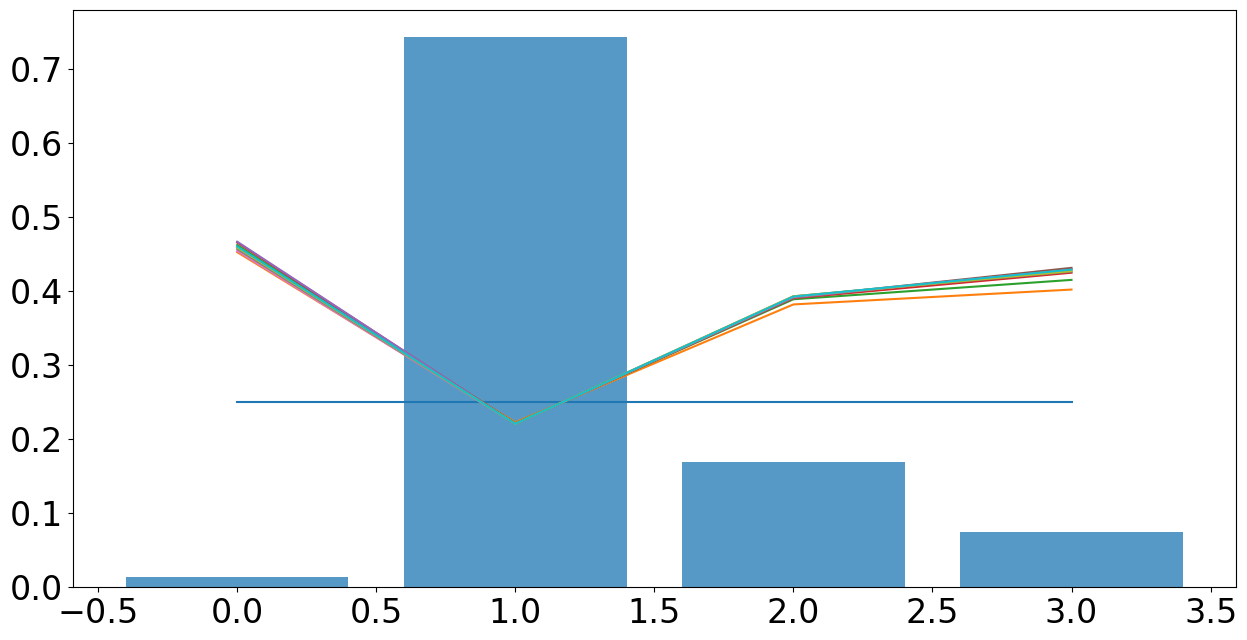

In [73]:
ttx=np.arange(0,prbs.shape[0])
plt.bar(ttx,prbs, alpha=0.75)
for n in range(Ns.shape[0]):
    ttprbs=np.exp(lqs[:,n])#/np.sum(np.exp(lqs[:,n]))
    plt.plot(ttx,ttprbs)

(array([0.02, 0.74, 0.16, 0.08]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

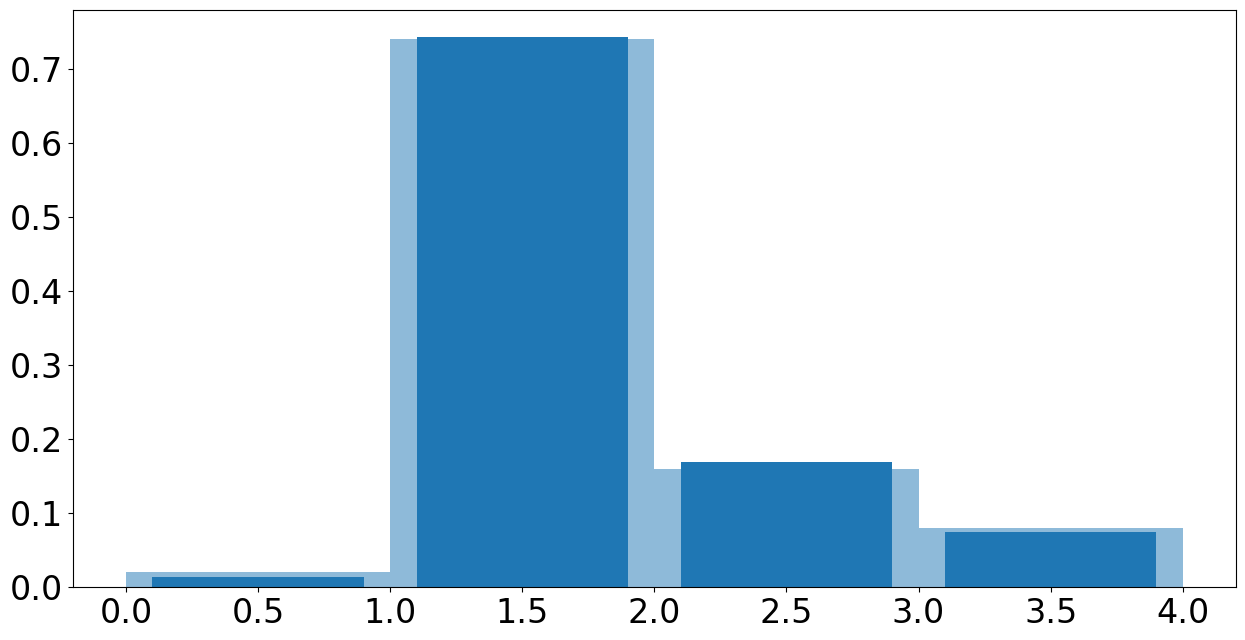

In [74]:
plt.bar(ttx+0.5,prbs, alpha=1)
plt.hist(samples[:,-1],density=True,bins=[0,1,2,3,4],alpha=0.5)

In [75]:
joint=np.zeros((prbs.shape[0],us.shape[0]))
for m in range(M):
    for i in range(us.shape[0]):
        joint[m,i]=lqN(m*np.ones(1,dtype=int),us[i]*np.ones(1),10,lq0,prbs,xi)
    # end for
# end for

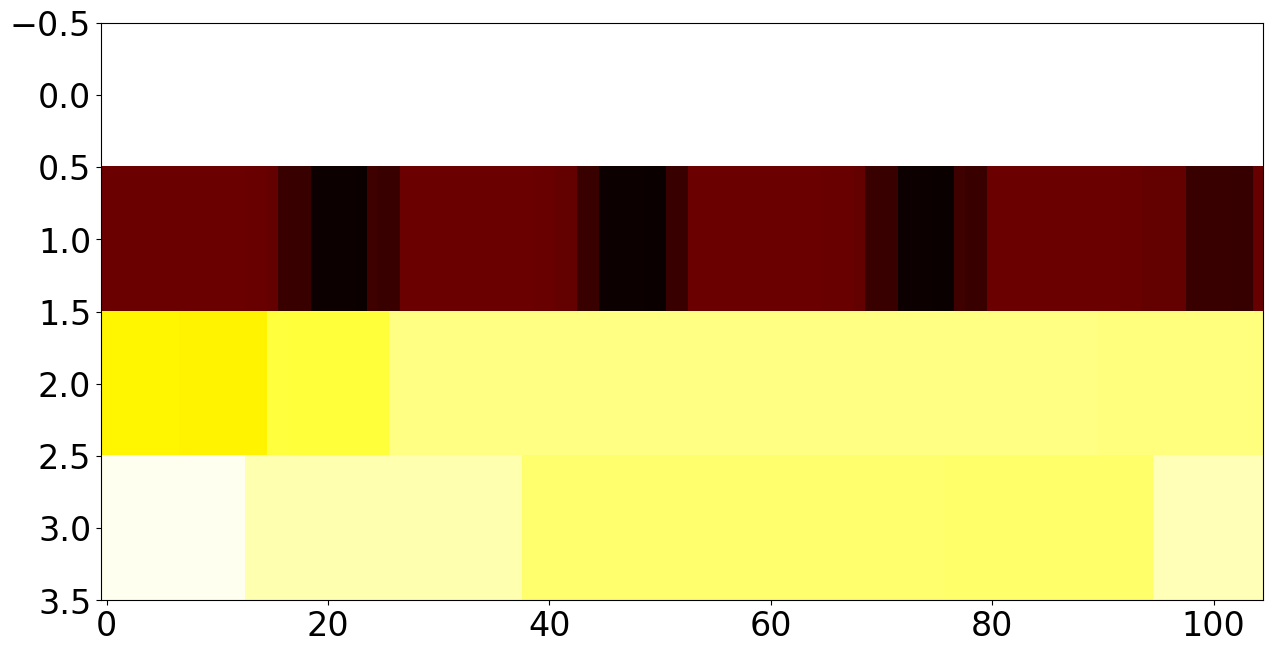

In [76]:
plt.imshow(joint, cmap='hot', interpolation='nearest', aspect='auto')

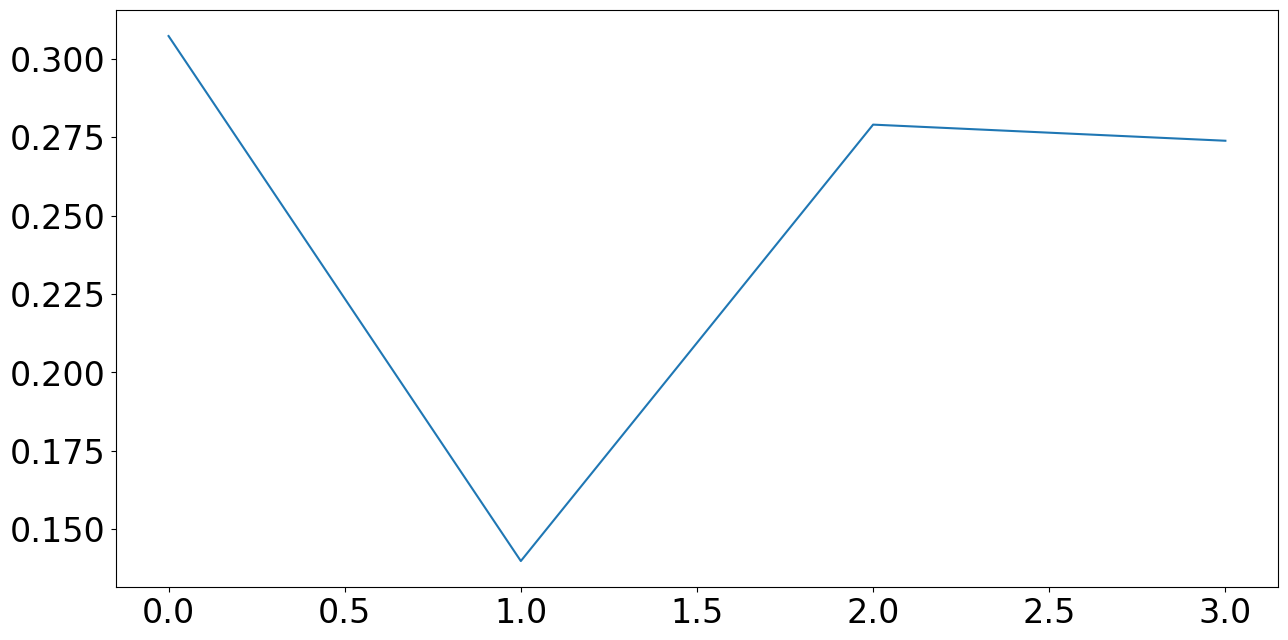

In [77]:
plt.plot(ttx,np.exp(joint[:,50])/np.sum(np.exp(joint[:,50])))

### Inversion diagnostic

Since this map is easily invertible,
we push the final particle back for 1,000 iterations to ensure that it reaches the original point.

In [ ]:
# backward map
tu=u[-1]
tx=x[-1]
print('Final (u,x)=('+str(tu)+','+str(tx+1)+')')
for it in range(n_iters):
    tx,tu=update(tx,tu,prbs,xi,'bwd')
# end for
print('Initial (u,x)=('+str(tu)+','+str(tx+1)+')')

We got the same $x$ labels, but the uniform variate is ever so slightly different.
In particular, the difference is of the order of $10^{15}$.
However, as we'll see later on, these differences add up to big deviations.

### Uniformity test

Here we study the trace of the uniform variate.
Notice that there is a clear pattern,
which is expected from the simple lcg update.

In [ ]:
plt.clf()
plt.scatter(np.arange(1,n_iters+1),u[1:])

### Quality of empirical approximation

Now we estimate the marginal empirical probability distribution of $X$ after all iterations.
The final approximation is good,
and we note that it doesn't take too long for the probabilities to stabilize around their true values.

In [ ]:
eprbs=plt.hist(x,bins=np.arange(prbs.shape[0]+1),density=True)[0]
plt.clf()
print('True: '+str(prbs))
print('Empirical: '+str(eprbs))

In [ ]:
freqs=np.zeros((int(n_iters/10)-1,prbs.shape[0]))

i=0
for it in 10*np.arange(1,n_iters/10):
    freqs[i,:]=plt.hist(x[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    i=i+1
plt.clf()

colors=['#3F4788','#238A8D','#DCE318','#DD5E66']

for n in range(prbs.shape[0]):
    plt.plot(10*np.arange(1,n_iters/10),freqs[:,n],c=colors[n], label='P(X='+str(n)+')',ls='dashed')
    plt.hlines(prbs[n],0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)

## Bivariate example

Now we consider a random 4x4 bivariate density.
(As before, we take Trevor's example to compare.)
We now run 10,000 iterations of the chain.

In [ ]:
np.random.seed(2022)
prbs=np.array([[0.0903257, 0.031233, 0.0648814, 0.0201844],
 [0.022866, 0.0872383, 0.00311221, 0.0900461],
 [0.0612982, 0.0145122, 0.03126, 0.120812],
 [0.13305, 0.0718069, 0.0893575, 0.0680155]]) # trevor's example
#prbs=np.random.rand(4,4)
prbs=prbs/np.sum(prbs)
print(prbs)

In [ ]:
# demo
n_iters=100000
xi=np.pi/16
x=np.zeros(n_iters+1,dtype=int)
y=np.zeros(n_iters+1,dtype=int)+2
u=np.zeros(n_iters+1)
v=np.zeros(n_iters+1)
u[0]=np.random.rand()
v[0]=np.random.rand()
u[0]=0.2654657001673143 # trevor's example
v[0]=0.40302657652555507 # trevor's example

print('Initial (u,x)=('+str(u[0])+','+str(x[0]+1)+')   (v,y)=('+str(v[0])+','+str(y[0]+1)+')')

# forward map
for it in range(n_iters):
    # step in (x,u)
    xprbs=prbs[:,y[it]]/np.sum(prbs[:,y[it]])
    tmpx,tmpu=update(x[it],u[it],xprbs)
    x[it+1]=tmpx
    u[it+1]=tmpu
    # step in (y,v)
    yprbs=prbs[x[it+1],:]/np.sum(prbs[x[it+1],:])
    tmpy,tmpv=update(y[it],v[it],yprbs)
    y[it+1]=tmpy
    v[it+1]=tmpv
# end for
print('Final (u,x)=('+str(u[-1])+','+str(x[-1]+1)+')   (v,y)=('+str(v[-1])+','+str(y[-1]+1)+')')

### Inversion diagnostic

As before, we push the final particle through the inverse map for 10,000 iterations.
Unlike before, however,
we no longer recover the original values!
This is probably due to numerical errors&mdash;i.e., instability in the numerical inversion.

In [ ]:
# backward map
tu=u[-1]
tx=x[-1]
tv=v[-1]
ty=y[-1]
print('Final (u,x)=('+str(tu)+','+str(tx+1)+')   (v,y)=('+str(tv)+','+str(ty+1)+')')
for it in range(n_iters):
    ty,tv=update(ty,tv,prbs[tx,:]/np.sum(prbs[tx,:]),xi,'bwd')
    tx,tu=update(tx,tu,prbs[:,ty]/np.sum(prbs[:,ty]),xi,'bwd')
# end for
print('Initial (u,x)=('+str(tu)+','+str(tx+1)+')   (v,y)=('+str(tv)+','+str(ty+1)+')')

### Uniformity test

Here we study the trace of the uniform variate.
Interestingly, there no longer appear to be any patterns in the uniform traceplot...
Still thinking why this is the case.
(This was also true in Trevor's example, btw.)

In [ ]:
plt.clf()
plt.scatter(np.arange(1,n_iters+1),u[1:], label='u', alpha=0.25,s=1)
plt.scatter(np.arange(1,n_iters+1),v[1:], label='v', alpha=0.25,s=1)
#plt.legend(fontsize='x-small',frameon=False)

### Quality of empirical approximation

Now we estimate the marginal empirical probability distribution of $(X,Y)$ after all iterations.
The final approximation is also good,
and we note that it again doesn't take too long for the probabilities to stabilize around their true values.

In [ ]:
eprbs=plt.hist2d(x,y,bins=[np.arange(prbs.shape[0]+1),np.arange(prbs.shape[1]+1)], density=True)[0]
plt.clf()
print('True: '+str(prbs))
print('Empirical: '+str(eprbs))

In [ ]:
binsize=100
xfreqs=np.zeros((int(n_iters/binsize)-1,prbs.shape[0]))
yfreqs=np.zeros((int(n_iters/binsize)-1,prbs.shape[0]))

i=0
for it in binsize*np.arange(1,n_iters/binsize):
    xfreqs[i,:]=plt.hist(x[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    yfreqs[i,:]=plt.hist(y[:int(it)],bins=np.arange(prbs.shape[0]+1),density=True)[0]
    i=i+1
plt.clf()

In [ ]:
for n in range(prbs.shape[0]):
    plt.plot(binsize*np.arange(1,n_iters/binsize),xfreqs[:,n],c=colors[n], label='P(X='+str(n)+')',ls='dashed')
    plt.hlines(np.sum(prbs[n,:]),0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)

In [ ]:
for n in range(prbs.shape[0]):
    plt.plot(binsize*np.arange(1,n_iters/binsize),yfreqs[:,n],c=colors[n], label='P(Y='+str(n)+')',ls='dashed')
    plt.hlines(np.sum(prbs[:,n]),0,n_iters,colors=colors[n])
# end for
plt.xlabel('iter #')
plt.ylabel('prob')
plt.legend(fontsize='x-small',loc='center right',frameon=False)